In [1]:
import pandas as pd
from itertools import takewhile
import plotly.graph_objects as go
import base64
import numpy as np
from dare_viz import path

In [2]:
xlsCH4 = pd.ExcelFile('GBR_2022_2020_10052022_142545.xlsx')
dfCH4 = pd.read_excel(xlsCH4, 'Table10s3', header=4)
dfCH4.set_index("GREENHOUSE GAS SOURCE AND SINK CATEGORIES", inplace=True)
dfCH4.dropna(inplace=True)

In [3]:
dfCH4.drop(
    labels = ["D.  Non-energy products from fuels and solvent use", "G.  Other product manufacture and use ", "C.  Rice cultivation", "D.  Agricultural soils", "E.  Prescribed burning of savannas", "F.  Other land", "E.  Other ","6.  Other (as specified in summary 1.A)", "International bunkers", "Navigation", "Multilateral operations",
 "Aviation"],
    axis=0,
    inplace = True
)
dfCH4.drop(
    labels = ["Base year(1)", "Change from base to latest reported year"],
    axis=1,
    inplace = True
)
#dfCH4

Convert Inventory data to CO2equ

In [4]:
dfCH4_CO2_equ = dfCH4 / 1000 * 28
dfCH4_CO2_equ

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
GREENHOUSE GAS SOURCE AND SINK CATEGORIES,,,,,,,,,,,,,,,,,,,,,
1. Energy,41.893554,42.472735,41.944533,39.787822,31.377826,32.339153,30.594004,28.194927,25.55663,22.608398,...,10.840491,10.762349,9.459737,8.986685,8.50566,7.444011,7.365613,7.351718,7.111938,6.595589
A. Fuel combustion (sectoral approach),3.624305,3.76515,3.563885,3.643731,3.304415,2.863886,2.883697,2.667514,2.45005,2.514568,...,1.218327,1.214207,1.242826,1.20696,1.264301,1.301041,1.334846,1.385392,1.375673,1.350114
1. Energy industries,0.261169,0.260316,0.266051,0.277824,0.281686,0.293679,0.30172,0.310536,0.222834,0.341388,...,0.327719,0.315065,0.314769,0.35666,0.372519,0.396597,0.414089,0.424772,0.434235,0.427896
2. Manufacturing industries and construction,0.128494,0.131914,0.132401,0.122577,0.130581,0.127163,0.117903,0.108579,0.107059,0.105491,...,0.100137,0.094907,0.099944,0.114052,0.119652,0.12238,0.135329,0.145383,0.144203,0.150268
3. Transport,1.419076,1.402901,1.385766,1.324735,1.22381,1.122796,1.08195,1.005022,0.916582,0.849648,...,0.189919,0.169727,0.151375,0.140871,0.13113,0.123074,0.116773,0.11154,0.109367,0.085924
4. Other sectors,1.811582,1.966984,1.776751,1.915538,1.665393,1.317381,1.379339,1.240799,1.201178,1.215741,...,0.598531,0.63265,0.675057,0.593881,0.639762,0.657848,0.667496,0.702527,0.686639,0.684981
5. Other,0.003983,0.003036,0.002916,0.003058,0.002946,0.002867,0.002785,0.002577,0.002396,0.0023,...,0.002021,0.001858,0.001681,0.001495,0.001239,0.001143,0.001159,0.001171,0.00123,0.001046
B. Fugitive emissions from fuels,38.269249,38.707585,38.380648,36.144091,28.073411,29.475267,27.710308,25.527413,23.10658,20.09383,...,9.622164,9.548141,8.216911,7.779725,7.241359,6.142969,6.030768,5.966326,5.736265,5.245475
1. Solid fuels,24.44608,25.139311,24.930209,23.214902,15.426876,16.870455,15.613115,14.966419,12.749394,10.55929,...,2.743344,2.762839,1.90907,1.88381,1.550668,0.567364,0.546302,0.527101,0.547649,0.531666


Read in InTEM data

In [5]:
def read_intem(species):

    fname = path() / f"data/intem/Table_UK_2021_{species}.txt"

    with open(fname, "r") as f:
        headiter = takewhile(lambda s: s.startswith('#'), f)
        header = list(headiter)

    df = pd.read_csv(fname,
                    sep=",",
                    skipinitialspace=True,
                    index_col="Year",
                    comment="#")

    df = df.apply(pd.to_numeric, errors='ignore')
    df.index = pd.to_datetime(df.index, format='%Y')
    df.rename(columns = {"Invent2021": "Invent"}, inplace=True)

    for h in header:
        if "GAS" in h:
            species_str = h.split(":")[1].strip()
        if "UNITS" in h:
            species_units = h.split(":")[1].strip()
        if "GWP" in h:
            species_gwp = float(h.split(":")[1].strip())
    
    return df, species_str, species_units, species_gwp

In [6]:
df_ch4, _, _, _ = read_intem("ch4")
df_n2o, _, _, _ = read_intem("n2o")

Break down emissions by sectors

In [7]:
df_ch4["InTEM_Energy"] = df_ch4["InTEM"] *0.183633889
df_ch4["InTEM_Energy_std"] = df_ch4["InTEM_std"] *0.183633889

df_ch4["InTEM_Industry"] = df_ch4["InTEM"] *0.001786693
df_ch4["InTEM_Industry_std"] = df_ch4["InTEM_std"] *0.001786693

df_ch4["InTEM_Agriculture"] = df_ch4["InTEM"] *0.294217933
df_ch4["InTEM_Agriculture_std"] = df_ch4["InTEM_std"] *0.294217933

df_ch4["InTEM_LULUCF"] = df_ch4["InTEM"] *0.051991413
df_ch4["InTEM_LULUCF_std"] = df_ch4["InTEM_std"] *0.051991413

df_ch4["InTEM_Waste"] = df_ch4["InTEM"] *0.468370072
df_ch4["InTEM_Waste_std"] = df_ch4["InTEM_std"] *0.468370072

df_ch4

,Invent,Invent_std,InTEM,InTEM_std,InTEM_Energy,InTEM_Energy_std,InTEM_Industry,InTEM_Industry_std,InTEM_Agriculture,InTEM_Agriculture_std,InTEM_LULUCF,InTEM_LULUCF_std,InTEM_Waste,InTEM_Waste_std
Year,,,,,,,,,,,,,,
1990-01-01,150.08,17.92,62.16,10.36,11.414683,1.902447,0.111061,0.018510,18.288587,3.048098,3.231786,0.538631,29.113884,4.852314
1991-01-01,150.64,17.92,61.88,9.80,11.363265,1.799612,0.110561,0.017510,18.206206,2.883336,3.217229,0.509516,28.982740,4.590027
1992-01-01,150.64,17.64,56.00,9.24,10.283498,1.696777,0.100055,0.016509,16.476204,2.718574,2.911519,0.480401,26.228724,4.327739
1993-01-01,148.96,17.36,57.40,9.24,10.540585,1.696777,0.102556,0.016509,16.888109,2.718574,2.984307,0.480401,26.884442,4.327739
1994-01-01,141.12,16.24,64.12,8.68,11.774605,1.593942,0.114563,0.015508,18.865254,2.553812,3.333689,0.451285,30.031889,4.065452
1995-01-01,143.08,16.24,59.36,7.84,10.900508,1.439690,0.106058,0.014008,17.464777,2.306669,3.086210,0.407613,27.802447,3.672021
1996-01-01,142.24,15.96,72.24,8.40,13.265712,1.542525,0.129071,0.015008,21.254303,2.471431,3.755860,0.436728,33.835054,3.934309
1997-01-01,139.72,15.40,62.44,8.40,11.466100,1.542525,0.111561,0.015008,18.370968,2.471431,3.246344,0.436728,29.245027,3.934309
1998-01-01,135.80,14.84,66.64,9.24,12.237362,1.696777,0.119065,0.016509,19.606683,2.718574,3.464708,0.480401,31.212182,4.327739


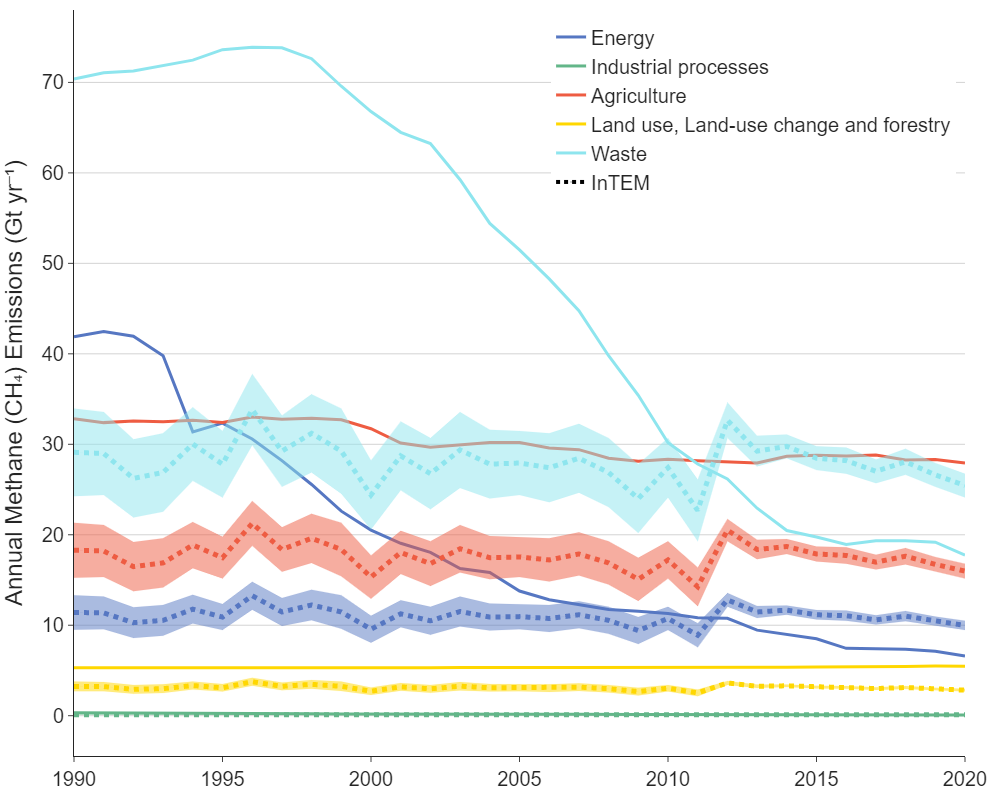

In [19]:
fig = go.Figure()

alpha = 0.6
color_1 = ["rgba(86, 119, 194, 1)", f"rgba(86, 119, 194, {alpha})"]
color_2 = ["rgba(99, 182, 137, 1)", f"rgba(99, 182, 137, {alpha})"]
color_3 = ["rgba(238,92,66, 1)", f"rgba(238,92,66, {alpha})"]
color_4 = ["rgba(255,215,0, 1)", f"rgba(255,215,0, {alpha})"]
color_5 = ["rgba(142,229,238, 1)", f"rgba(142,229,238, {alpha})"]
color_6 = ["rgba(0, 0, 0, 1)", f"rgba(0, 0, 0, {alpha})"]

date_range = [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

def errorbars(df, var, color, dash, name, showlegend=False):

    error_minus=df[var] - df[f"{var}_std"]
    error_plus=df[var] + df[f"{var}_std"]

    fig.add_trace(go.Scatter(
        x=date_range,
        y=error_minus.values,
        fill=None,
        mode='lines',
        line=dict(color=color[1], width=0.1),
        showlegend=False,
        hoverinfo='skip'
        ))

    fig.add_trace(go.Scatter(
        x=date_range,
        y=error_plus.values,
        fill="tonexty",
        mode='lines',
        line=dict(color=color[1], width=0.1),
        showlegend=False,
        hoverinfo='skip'
        ))
    
    fig.add_trace(go.Scatter(
        x=date_range,
        y=df[var],
        mode="lines",
        line=dict(color=color[0], dash="dot", width=0.1),
        showlegend=showlegend,
        name=name,
        hovertemplate = 'InTEM %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
        ))

#date_range = ["2019-03-01", "2019-06-01"]

fig.add_trace(go.Scatter(
    x=date_range,
    y=dfCH4_CO2_equ.loc["1. Energy"],
    mode='lines',
    line=dict(color=color_1[0], width=3.),
    showlegend=True,
    hovertemplate = 'Inventory Energy %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="Energy",
    ))

fig.add_trace(go.Scatter(
    x=date_range,
    y=dfCH4_CO2_equ.loc["2.  Industrial processes"],
    mode='lines',
    line=dict(color=color_2[0], width=3.),
    showlegend=True,
    hovertemplate = 'Inventory Industrial Processes %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="Industrial processes",
    ))

fig.add_trace(go.Scatter(
    x=date_range,
    y=dfCH4_CO2_equ.loc["3.  Agriculture"],
    mode='lines',
    line=dict(color=color_3[0], width=3.),
    showlegend=True,
    hovertemplate = 'Inventory Agriculture %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="Agriculture",
    ))

fig.add_trace(go.Scatter(
    x=date_range,
    y=dfCH4_CO2_equ.loc["4. Land use, land-use change and forestry"],
    mode='lines',
    line=dict(color=color_4[0], width=3.),
    showlegend=True,
    hovertemplate = 'Inventory LULUCF %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="Land use, Land-use change and forestry",
    ))

fig.add_trace(go.Scatter(
    x=date_range,
    y=dfCH4_CO2_equ.loc["5.  Waste"],
    mode='lines',
    line=dict(color=color_5[0], width=3.),
    showlegend=True,
    hovertemplate = 'Inventory Waste %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="Waste",
    ))

errorbars(df_ch4, "InTEM_Energy", color_1, None, "InTEM")
fig.add_trace(go.Scatter(
    x=date_range,
    y=df_ch4["InTEM_Energy"],
    mode='lines',
    line=dict(color=color_1[0], dash="dot", width=5),
    showlegend=False,
    hovertemplate = 'InTEM Energy %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="InTEM",
    ))

errorbars(df_ch4, "InTEM_Industry", color_2, None, "InTEM")
fig.add_trace(go.Scatter(
    x=date_range,
    y=df_ch4["InTEM_Industry"],
    mode='lines',
    line=dict(color=color_2[0], dash="dot", width=5),
    showlegend=False,
    hovertemplate = 'InTEM Industrial Processes %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="InTEM",
    ))

errorbars(df_ch4, "InTEM_Agriculture", color_3, None, "InTEM")
fig.add_trace(go.Scatter(
    x=date_range,
    y=df_ch4["InTEM_Agriculture"],
    mode='lines',
    line=dict(color=color_3[0], dash="dot", width=5),
    showlegend=False,
    hovertemplate = 'InTEM Agriculture %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="InTEM",
    ))

errorbars(df_ch4, "InTEM_LULUCF", color_4, None, "InTEM")
fig.add_trace(go.Scatter(
    x=date_range,
    y=df_ch4["InTEM_LULUCF"],
    mode='lines',
    line=dict(color=color_4[0], dash="dot", width=5),
    showlegend=False,
    hovertemplate = 'InTEM LULUCF %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="InTEM",
    ))

errorbars(df_ch4, "InTEM_Waste", color_5, None, "InTEM")
fig.add_trace(go.Scatter(
    x=date_range,
    y=df_ch4["InTEM_Waste"],
    mode='lines',
    line=dict(color=color_5[0], dash="dot", width=5),
    showlegend=False,
    hovertemplate = 'InTEM Waste %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="InTEM",
    ))

fig.add_trace(go.Scatter(
    x=[pd.Timestamp("1900-01-01"), pd.Timestamp("1900-01-02")],
    y=[0., 0.],
    line=dict(color="black", dash="dot", width=4),
    marker=dict(opacity=0., size=0),
    showlegend=True,
    name="InTEM"
    ))

#fig.add_trace(go.Scatter(
#    x=date_range,
#    y=df_ch4["InTEM"],
#    mode='lines',
#    line=dict(color=color_6[0], dash="dot", width=5),
#    showlegend=False,
#    hovertemplate = 'Inventory %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
#   name="InTEM",
#    ))


fig.update_layout(
    yaxis_title="Annual Methane (CH₄) Emissions (Gt yr⁻¹)",
    template="simple_white",
    autosize=False,
    width=550*2,
    height=400*2,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
        traceorder="normal"),
    margin=dict(l=55, r=10, t=10, b=40),
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor='rgba(0,0,0,0)'
)

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='Lightgrey')


fig.layout.font.size=20
fig.layout.font.family="Arial"

fig.write_image("Annual_methane_emissions_by_sector_BOTH.png")
fig.write_html("Annual_methane_emissions_by_sector_BOTH.html")

fig.show()

N2O data

In [11]:
xlsN2O = pd.ExcelFile('GBR_2022_2020_10052022_142545.xlsx')
dfN2O = pd.read_excel(xlsN2O, 'Table10s4', header=4)
dfN2O.set_index("GREENHOUSE GAS SOURCE AND SINK CATEGORIES", inplace=True)
dfN2O.dropna(inplace=True)
#dfN2O

In [12]:
dfN2O.drop(
    labels = ["D.  Non-energy products from fuels and solvent use",  "E.  Prescribed burning of savannas", "F.  Other land", "E.  Other ","6.  Other (as specified in summary 1.A)", "International bunkers", "Navigation", "Multilateral operations",
 "Aviation", "Indirect N2O", "H.  Other "],
    axis=0,
    inplace = True
)
dfN2O.drop(
    labels = ["Base year(1)", "Change from base to latest reported year"],
    axis=1,
    inplace = True
)
#dfN2O

In [13]:
dfN2O_CO2_equ = dfN2O / 1000 * 265
dfN2O_CO2_equ

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
GREENHOUSE GAS SOURCE AND SINK CATEGORIES,,,,,,,,,,,,,,,,,,,,,
1. Energy,3.285956,3.264935,3.213452,3.181361,3.251002,3.339232,3.208507,3.107244,3.128601,3.058019,...,2.150863,2.309117,2.286534,2.222302,2.242441,2.109777,2.100562,2.131208,2.09926,1.915408
A. Fuel combustion (sectoral approach),3.246137,3.22632,3.174377,3.140323,3.199995,3.285275,3.153251,3.058091,3.078366,3.01708,...,2.107613,2.276149,2.255225,2.191072,2.210777,2.077081,2.067539,2.097989,2.066384,1.88792
1. Energy industries,1.27773,1.264945,1.223495,1.105359,1.074818,1.0574,1.01698,0.954882,1.003794,0.941172,...,0.874099,1.016464,0.984988,0.881654,0.850826,0.676562,0.633491,0.64059,0.635226,0.623444
2. Manufacturing industries and construction,0.280459,0.278801,0.276218,0.26722,0.277231,0.267541,0.25793,0.244279,0.241303,0.23274,...,0.180455,0.183006,0.167014,0.185669,0.198402,0.199893,0.218895,0.233418,0.221835,0.222871
3. Transport,1.282627,1.262918,1.285411,1.359839,1.479657,1.642836,1.549639,1.552822,1.540839,1.552278,...,0.871175,0.889941,0.914265,0.94909,0.984138,1.020617,1.034983,1.038684,1.026816,0.863881
4. Other sectors,0.355414,0.377863,0.349621,0.368397,0.33065,0.280404,0.292241,0.270832,0.262208,0.260693,...,0.155613,0.162673,0.167131,0.155482,0.161833,0.16545,0.165194,0.169944,0.166119,0.164571
5. Other,0.049908,0.041793,0.039633,0.039507,0.037639,0.037094,0.036461,0.035277,0.030223,0.030197,...,0.026271,0.024065,0.021828,0.019177,0.015578,0.01456,0.014975,0.015353,0.016388,0.013153
B. Fugitive emissions from fuels,0.039819,0.038615,0.039075,0.041039,0.051007,0.053957,0.055257,0.049153,0.050235,0.04094,...,0.04325,0.032969,0.031308,0.03123,0.031663,0.032696,0.033023,0.033219,0.032875,0.027488
1. Solid fuels,0.00008,0.000033,0.000023,0.00004,0.000023,0.000026,0.000025,0.000017,0.000029,0.000015,...,0.000065,0.000016,0.000033,0.000059,0.000066,0.000017,0.000016,0.00001,0.000014,0.000015


In [14]:
df_n2o["InTEM_Energy"] = df_n2o["InTEM"] *0.100978825
df_n2o["InTEM_Energy_std"] = df_n2o["InTEM_std"] *0.100978825

df_n2o["InTEM_Industry"] = df_n2o["InTEM"] *0.234918098
df_n2o["InTEM_Industry_std"] = df_n2o["InTEM_std"] *0.234918098

df_n2o["InTEM_Agriculture"] = df_n2o["InTEM"] *0.549240911
df_n2o["InTEM_Agriculture_std"] = df_n2o["InTEM_std"] *0.549240911

df_n2o["InTEM_LULUCF"] = df_n2o["InTEM"] *0.070015981
df_n2o["InTEM_LULUCF_std"] = df_n2o["InTEM_std"] *0.070015981

df_n2o["InTEM_Waste"] = df_n2o["InTEM"] *0.044846185
df_n2o["InTEM_Waste_std"] = df_n2o["InTEM_std"] *0.044846185
df_n2o

,Invent,Invent_std,InTEM,InTEM_std,InTEM_Energy,InTEM_Energy_std,InTEM_Industry,InTEM_Industry_std,InTEM_Agriculture,InTEM_Agriculture_std,InTEM_LULUCF,InTEM_LULUCF_std,InTEM_Waste,InTEM_Waste_std
Year,,,,,,,,,,,,,,
1990-01-01,43.990,6.519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-01-01,44.255,6.439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-01,39.750,5.697,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-01-01,36.040,5.061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-01,36.570,5.061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-01,35.510,4.823,23.532,5.099,2.376234,0.514891,5.528093,1.197847,12.924737,2.800579,1.647616,0.357011,1.055320,0.228671
1996-01-01,35.510,4.717,33.655,5.141,3.398442,0.519132,7.906169,1.207714,18.484703,2.823648,2.356388,0.359952,1.509298,0.230554
1997-01-01,35.775,4.664,28.090,5.803,2.836495,0.585980,6.598849,1.363230,15.428177,3.187245,1.966749,0.406303,1.259729,0.260242
1998-01-01,35.775,4.558,33.390,5.618,3.371683,0.567299,7.843915,1.319770,18.339154,3.085635,2.337834,0.393350,1.497414,0.251946


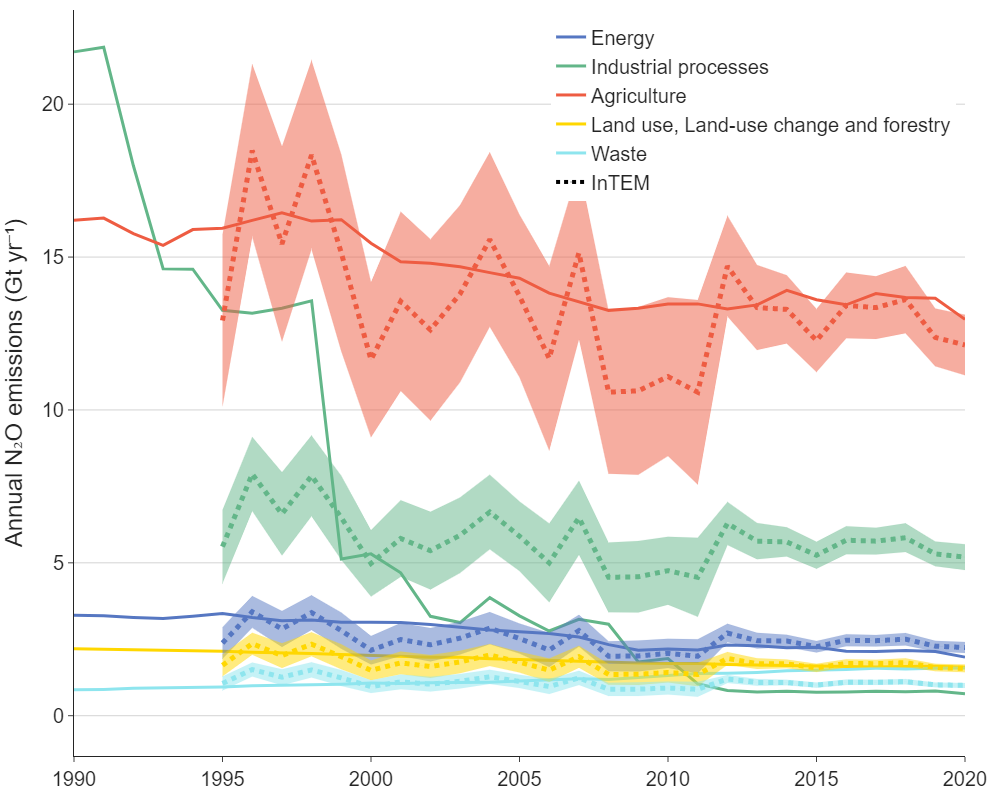

In [18]:
fig1 = go.Figure()

alpha = 0.6
color_1 = ["rgba(86, 119, 194, 1)", f"rgba(86, 119, 194, {alpha})"]
color_2 = ["rgba(99, 182, 137, 1)", f"rgba(99, 182, 137, {alpha})"]
color_3 = ["rgba(238,92,66, 1)", f"rgba(238,92,66, {alpha})"]
color_4 = ["rgba(255,215,0, 1)", f"rgba(255,215,0, {alpha})"]
color_5 = ["rgba(142,229,238, 1)", f"rgba(142,229,238, {alpha})"]
color_6 = ["rgba(0, 0, 0, 1)", f"rgba(0, 0, 0, {alpha})"]

date_range = [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
#date_range = ["2019-03-01", "2019-06-01"]

def errorbars(df, var, color, dash, name, showlegend=False):

    error_minus=df[var] - df[f"{var}_std"]
    error_plus=df[var] + df[f"{var}_std"]

    fig1.add_trace(go.Scatter(
        x=date_range,
        y=error_minus.values,
        fill=None,
        mode='lines',
        line=dict(color=color[1], width=0.1),
        showlegend=False,
        hoverinfo='skip'
        ))

    fig1.add_trace(go.Scatter(
        x=date_range,
        y=error_plus.values,
        fill="tonexty",
        mode='lines',
        line=dict(color=color[1], width=0.1),
        showlegend=False,
        hoverinfo='skip'
        ))
    
    fig1.add_trace(go.Scatter(
        x=date_range,
        y=df[var],
        mode="lines",
        line=dict(color=color[0], dash="dot", width = 0.1),
        showlegend=showlegend,
        name=name,
        hovertemplate = 'InTEM %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
        ))

fig1.add_trace(go.Scatter(
    x=date_range,
    y=dfN2O_CO2_equ.loc["1. Energy"],
    mode='lines',
    line=dict(color=color_1[0], width=3.),
    showlegend=True,
    hovertemplate = 'InTEM Energy %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="Energy",
    ))

fig1.add_trace(go.Scatter(
    x=date_range,
    y=dfN2O_CO2_equ.loc["2.  Industrial processes"],
    mode='lines',
    line=dict(color=color_2[0], width=3.),
    showlegend=True,
    hovertemplate = 'InTEM Industrial Processes %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="Industrial processes",
    ))

fig1.add_trace(go.Scatter(
    x=date_range,
    y=dfN2O_CO2_equ.loc["3.  Agriculture"],
    mode='lines',
    line=dict(color=color_3[0], width=3.),
    showlegend=True,
    hovertemplate = 'InTEM Agriculture %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="Agriculture",
    ))

fig1.add_trace(go.Scatter(
    x=date_range,
    y=dfN2O_CO2_equ.loc["4. Land use, land-use change and forestry"],
    mode='lines',
    line=dict(color=color_4[0], width=3.),
    showlegend=True,
    hovertemplate = 'InTEM LULUCF %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="Land use, Land-use change and forestry",
    ))

fig1.add_trace(go.Scatter(
    x=date_range,
    y=dfN2O_CO2_equ.loc["5.  Waste"],
    mode='lines',
    line=dict(color=color_5[0], width=3.),
    showlegend=True,
    hovertemplate = 'InTEM Waste %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="Waste",
    ))

errorbars(df_n2o, "InTEM_Energy", color_1, None, "InTEM")
fig1.add_trace(go.Scatter(
    x=date_range,
    y=df_n2o["InTEM_Energy"],
    mode='lines',
    line=dict(color=color_1[0], dash="dot", width=5),
    showlegend=False,
    hovertemplate = 'InTEM Energy %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="InTEM",
    ))

errorbars(df_n2o, "InTEM_Industry", color_2, None, "InTEM")
fig1.add_trace(go.Scatter(
    x=date_range,
    y=df_n2o["InTEM_Industry"],
    mode='lines',
    line=dict(color=color_2[0], dash="dot", width=5),
    showlegend=False,
    hovertemplate = 'InTEM Industrial Processes %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="InTEM",
    ))

errorbars(df_n2o, "InTEM_Agriculture", color_3, None, "InTEM")
fig1.add_trace(go.Scatter(
    x=date_range,
    y=df_n2o["InTEM_Agriculture"],
    mode='lines',
    line=dict(color=color_3[0], dash="dot", width=5),
    showlegend=False,
    hovertemplate = 'InTEM Agriculture %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="InTEM",
    ))

errorbars(df_n2o, "InTEM_LULUCF", color_4, None, "InTEM")
fig1.add_trace(go.Scatter(
    x=date_range,
    y=df_n2o["InTEM_LULUCF"],
    mode='lines',
    line=dict(color=color_4[0], dash="dot", width=5),
    showlegend=False,
    hovertemplate = 'InTEM LULUCF %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="InTEM",
    ))

errorbars(df_n2o, "InTEM_Waste", color_5, None, "InTEM")
fig1.add_trace(go.Scatter(
    x=date_range,
    y=df_n2o["InTEM_Waste"],
    mode='lines',
    line=dict(color=color_5[0], dash="dot", width=5),
    showlegend=False,
    hovertemplate = 'InTEM Waste %{x|%Y}: %{y:.0f} Gt yr⁻¹<extra></extra>',
    name="InTEM",
    ))

fig1.add_trace(go.Scatter(
    x=[pd.Timestamp("1900-01-01"), pd.Timestamp("1900-01-02")],
    y=[0., 0.],
    line=dict(color="black", dash="dot", width=4),
    marker=dict(opacity=0., size=0),
    showlegend=True,
    name="InTEM"
    ))

fig1.update_layout(
    yaxis_title="Annual N₂O emissions (Gt yr⁻¹)",
    template="simple_white",
    autosize=False,
    width=550*2,
    height=400*2,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99,
        traceorder="normal"),
    margin=dict(l=55, r=10, t=10, b=40),
    # paper_bgcolor='rgba(0,0,0,0)',
    # plot_bgcolor='rgba(0,0,0,0)'
)

fig1.update_yaxes(showgrid=True, gridwidth=1, gridcolor='Lightgrey')

fig1.layout.font.size=20
fig1.layout.font.family="Arial"

fig1.write_image("Annual_N2O_emissions_by_sector_BOTH.png")
fig1.write_html("Annual_N2O_emissions_by_sector_BOTH.html")

fig1.show()